In [76]:
import GEMS
import pandas as pd
import numpy as np
import os
import cobra

import pickle
from arrhenius_etcpy import arrhenius_etc
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [77]:
path = '../'
params = pd.read_csv(os.path.join(path,'data/model_enzyme_params.csv'),index_col=0)
dfae_batch,dfan_batch = GEMS.load_exp_batch_data(os.path.join(path,'data/ExpGrowth.tsv'))
dfchemo = pd.read_csv(os.path.join(path,'data/Chemostat_exp_data.txt'),sep='\t',index_col=0)

Parameter Threads unchanged
   Value: 4  Min: 0  Max: 1024  Default: 0


In [78]:
def aerobic(params):
    # thermalParams: a dictionary with ids like uniprotid_Topt 
    df = arrhenius_etc.calculate_thermal_params(params)
    mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))
    
    try: rae = arrhenius_etc.simulate_growth(mae,dfae_batch.index+273.15,df=df,sigma=0.5)
    except: rae = np.zeros(dfae_batch.shape[0])
    
    rae = [0 if x is None else x for x in rae]
    rae = [0 if x<1e-3 else x for x in rae]
    print(rae)
    rexp = GEMS.aerobic_exp_data()['data']
    
    print('r2_batch:',r2_score(rexp,rae))
    print('MSE_ae',MSE(rexp,rae))
    return {'data':np.array(rae)}

In [79]:
params

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std
O13525,310.15,13,335,324.625351,5.91247,NaN,-6300,2000
P00044,314.15,13,109,321.817780,3.40000,324.65,-6300,2000
P00045,317.15,13,113,324.625351,5.91247,NaN,-6300,2000
P00127,317.15,13,147,324.625351,5.91247,NaN,-6300,2000
P00128,309.15,13,127,324.625351,5.91247,NaN,-6300,2000
...,...,...,...,...,...,...,...,...
P81451,307.15,13,68,324.625351,5.91247,NaN,-6300,2000
P00401,310.15,13,534,324.625351,5.91247,NaN,-6300,2000
P00410,308.15,13,251,324.625351,5.91247,NaN,-6300,2000
P00420,311.15,13,269,324.625351,5.91247,NaN,-6300,2000


In [80]:
useable_T90_frame = (
    params.
    loc[np.isfinite(params['T90'])].
    assign(melting_point_difference = lambda df: df.T90 - df.Tm)
    )
melting_point_difference_mean = useable_T90_frame['melting_point_difference'].mean()

In [81]:
melting_point_difference_mean

3.0549373458113154

In [82]:
params.T90[np.isnan(params.T90)] = params.Tm + melting_point_difference_mean

/tmp/ipykernel_2168539/2304606689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params.T90[np.isnan(params.T90)] = params.Tm + melting_point_difference_mean


In [83]:
thermalparams = arrhenius_etc.calculate_thermal_params(params=params)
thermalparams

,Ea,dHeq,Tm,Topt
O13525,63608.464130,636084.641304,324.625351,310.15
P00044,67388.060553,673880.605530,321.817780,314.15
P00045,63608.464130,636084.641304,324.625351,317.15
P00127,63608.464130,636084.641304,324.625351,317.15
P00128,63608.464130,636084.641304,324.625351,309.15
...,...,...,...,...
P81451,63608.464130,636084.641304,324.625351,307.15
P00401,63608.464130,636084.641304,324.625351,310.15
P00410,63608.464130,636084.641304,324.625351,308.15
P00420,63608.464130,636084.641304,324.625351,311.15


In [84]:
def compute_fNT_from_thermal_params(enzymes, T):
    dHeq, Tm = thermalparams.loc[enzymes, ['dHeq', 'Tm']].T.to_numpy()
    return arrhenius_etc.calculate_fNT(T=T + 273.15, dHeq=dHeq, Tm=Tm)
index = pd.MultiIndex.from_product([thermalparams.index, np.linspace(start=10,stop=50,num=1000)], names=['enzyme', 'Temperature'])
denaturation_frame = pd.DataFrame(index=index).reset_index().assign(fNT = lambda df: compute_fNT_from_thermal_params(enzymes=df.enzyme, T=df.Temperature))
denaturation_frame

,enzyme,Temperature,fNT
0,O13525,10.00000,1.000000
1,O13525,10.04004,1.000000
2,O13525,10.08008,1.000000
3,O13525,10.12012,1.000000
4,O13525,10.16016,1.000000
...,...,...,...
763995,P00163,49.83984,0.767349
763996,P00163,49.87988,0.762066
763997,P00163,49.91992,0.756703
763998,P00163,49.95996,0.751260


In [85]:
denaturation_frame.query('Temperature < 40').sort_values('fNT')

,enzyme,Temperature,fNT
29749,P00927,39.989990,0.563846
29748,P00927,39.949950,0.574825
29747,P00927,39.909910,0.585734
29746,P00927,39.869870,0.596562
390749,P38013,39.989990,0.596655
...,...,...,...
389715,P38009,38.628629,1.000000
389716,P38009,38.668669,1.000000
389717,P38009,38.708709,1.000000
389719,P38009,38.788789,1.000000


In [86]:
def anaerobic(params):
    df = arrhenius_etc.calculate_thermal_params(params)
    man = pickle.load(open(os.path.join(path,'models/anaerobic.pkl'),'rb'))

    try: ran = arrhenius_etc.simulate_growth(man,dfan_batch.index+273.15,df=df,sigma=0.5)
    except: ran = np.zeros(dfan_batch.shape[0])
    ran = [0 if x is None else x for x in ran]
    rexp = GEMS.anaerobic_exp_data()['data']
    
    print('r2_batch_an:',r2_score(rexp,ran))
    print('MSE_an',MSE(rexp,ran))

    return  {'data':np.array(ran)}

In [87]:
def chemostat(params):
    
    mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))
    exp_flux = GEMS.chemostat_exp_data()['data']
    
    growth_id = 'r_2111'
    glc_up_id = 'r_1714_REV'
    prot_pool_id = 'prot_pool_exchange'
    dilut = 0.1
    sigma = 0.5
    
    try:
        solution = arrhenius_etc.simulate_chomostat(mae,dilut,params,dfchemo.index+273.15,
                                              sigma,growth_id,glc_up_id,prot_pool_id)

        # Extract fluxes
        rxn_lst = [
                'r_1714_REV',#Glucose
                'r_1672', #CO2
                'r_1761', # Ethanol
            ]
        columns = ['Glucose','CO2','Ethanol']

        pred_flux = []
        for i,rxn_id in enumerate(rxn_lst):
            x = [s.fluxes[rxn_id] for s in solution]
            x.extend([0]*(len(dfchemo.index)-len(x)))
            pred_flux += x
        print(pred_flux)
    
    except: pred_flux = [0 for item in exp_flux]
    
    print('r2_flux:',r2_score(exp_flux,pred_flux))
    print('MSE_chemo',MSE(exp_flux,pred_flux))

    return  {'data':np.array(pred_flux)}

In [88]:
rae = aerobic(params)

Read LP format model from file /tmp/tmpg9awfa_o.lp
Reading time = 0.02 seconds
: 3389 rows, 13486 columns, 49610 nonzeros
16.0 2.532769030921892e-11
22.0 1.1174185387756126e-06
26.0 0.001077538228716133
29.0 0.09903395694546538
34.0 0.3846888842928528
37.0 0.5267235810328885
40.0 0.7265841453033106
42.0 0.8541351567175207
[0, 0, 0.001077538228716133, 0.09903395694546538, 0.3846888842928528, 0.5267235810328885, 0.7265841453033106, 0.8541351567175207]
r2_batch: -13.283738376624136
MSE_ae 0.17370364966447763


In [14]:
rae

{'data': array([0.        , 0.        , 0.00107754, 0.09903396, 0.38468888,
        0.52672358, 0.72658415, 0.85413516])}

In [15]:
ran = anaerobic(params)

Read LP format model from file /tmp/tmpbe72x4ta.lp
Reading time = 0.02 seconds
: 3389 rows, 13486 columns, 49608 nonzeros
5.0 0.0
10.0 0.009479642968949601
15.0 0.031648178437040445
18.5 0.05813662354768515
22.5 0.10177344343289588
26.30000000000001 0.16194089470240183
30.0 0.23956785013275111
31.0 0.26163940974638195
33.0 0.30931113666583626
34.0 0.3396303802376215
35.0 0.3759936089761288
37.5 0.5013774061742491
40.0 0.6665039665045144
r2_batch_an: -1.8400002894546312
MSE_an 0.03570781097664086


In [16]:
chem  = chemostat(params)

Read LP format model from file /tmp/tmp62rosuj9.lp
Reading time = 0.04 seconds
: 3389 rows, 13486 columns, 49610 nonzeros
[1.0784201918239564, 1.3562481688893477, 1.3684950763251038, 1.374357493349424, 1.3803342104254401, 1.386550243264047, 2.851180990314684, 4.51814885270713, 4.591630297321562, 4.626804799467466, 4.662665101923578, 4.699961298955253, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
r2_flux: -0.35803249159938844
MSE_chemo 38.57505249944226


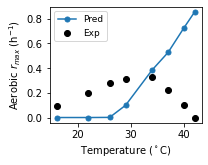

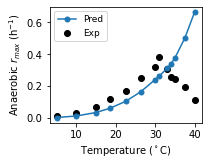

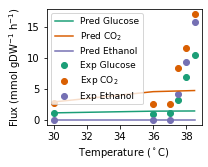

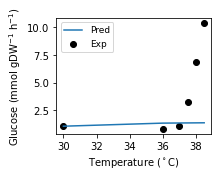

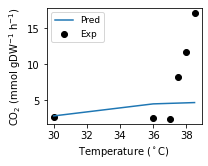

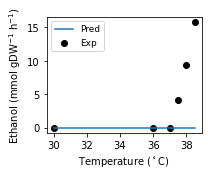

In [17]:
plt.figure(figsize=(3,2.4))
plt.scatter(dfae_batch.index,dfae_batch['r_ae'].values,label='Exp',color='k')
plt.plot(dfae_batch.index,rae['data'],markersize=5,marker='o',label='Pred')
plt.xlabel('Temperature ($^\circ$C)')
#plt.ylabel('Specific growth rate (h$^{-1}$)')
plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')

plt.legend(fontsize=9,loc='upper left')
plt.tight_layout()
plt.savefig('../figures/simulated_results_with_start_points_ae_batch.pdf')
plt.show()

plt.figure(figsize=(3,2.4))
plt.scatter(dfan_batch.index,dfan_batch['r_an'].values,label='Exp',color='k')
plt.plot(dfan_batch.index,ran['data'],markersize=5,marker='o',label='Pred')
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig('../figures/simulated_results_with_start_points_an_batch.pdf')
plt.show()

plt.figure(figsize=(3,2.4))
mets = ['Glucose','CO2','Ethanol']
labels = ['Glucose','CO$_2$','Ethanol']
cs = ['#1b9e77', '#d95f02', '#7570b3']
for i in range(3):
    plt.scatter(dfchemo.index, dfchemo[mets[i]],label='Exp {0}'.format(labels[i]),color=cs[i])
    plt.plot(dfchemo.index, chem['data'][i*6:(i+1)*6],label='Pred {0}'.format(labels[i]),color=cs[i])
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Flux (mmol gDW$^{-1}$ h$^{-1}$)')
plt.legend(fontsize=9)

plt.tight_layout()
plt.savefig('../figures/simulated_results_with_start_points_ae_chemo.pdf')
plt.show()


mets = ['Glucose','CO2','Ethanol']
labels = ['Glucose','CO$_2$','Ethanol']
cs = ['#1b9e77', '#d95f02', '#7570b3']
for i in range(3):
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfchemo.index, dfchemo[mets[i]],label='Exp'.format(labels[i]),color='k')
    plt.plot(dfchemo.index, chem['data'][i*6:(i+1)*6],label='Pred'.format(labels[i]))
    plt.xlabel('Temperature ($^\circ$C)')
    plt.ylabel(labels[i]+' (mmol gDW$^{-1}$ h$^{-1}$)')
    plt.legend(fontsize=9)

    plt.tight_layout()
    plt.savefig('../figures/simulated_results_with_start_points_ae_chemo_{0}.pdf'.format(mets[i]))
    plt.show()


# Extend the temperature range

In [57]:
def aerobic_temperatures_supplied(params, T):
    df = arrhenius_etc.calculate_thermal_params(params)
    mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))
    mae.solver.problem.setParam('Threads', 4)
    
    try: rae = arrhenius_etc.simulate_growth(mae, T + 273.15,df=df,sigma=0.5)
    except: rae = np.zeros(dfae_batch.shape[0])
    rae = [0 if x is None else x for x in rae]
    rae = [0 if x<1e-3 else x for x in rae]
    return {'data':np.array(rae)}

In [73]:
T = np.array([10, 20, 30, 38,40, 42, 44, 45, 46, 47, 48, 49, 50], dtype=np.float64)
aerobic_temperatures = aerobic_temperatures_supplied(params, T)

Read LP format model from file /tmp/tmpb8ch74fb.lp
Reading time = 0.03 seconds
: 3389 rows, 13486 columns, 49610 nonzeros
10.0 0.0
20.0 0.08164346543571765
30.0 0.2715248166081066
38.0 0.5883858122155308
40.0 0.7265823949043987
42.0 0.8541327182676515
44.0 0.7412833899866387
45.0 0.4720389585752273
46.0 0.21575408741965008
47.0 0.07867759195286442
48.0 0.02340996750595187
49.0 0.0048872600396171135
50.0 0.0006312194206082567


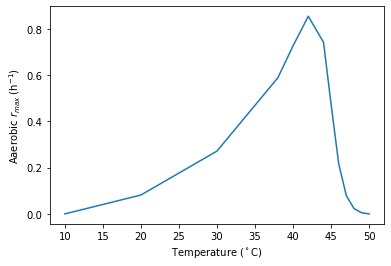

In [66]:
plt.plot(T, aerobic_temperatures['data'])
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Aaerobic $r_{max}$ (h$^{-1}$)');


In [89]:
mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))

Read LP format model from file /tmp/tmpq6yz1nps.lp
Reading time = 0.03 seconds
: 3389 rows, 13486 columns, 49610 nonzeros


In [97]:
type(mae.solver.problem.setParam('Threads', 4))

NoneType